In [1]:
import numpy as np
import pandas as pd
import onnxruntime as rt
import onnxmltools
import matplotlib.pyplot as plt
from skl2onnx import to_onnx
from hyperopt import fmin, tpe, hp, Trials
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [2]:
data = pd.read_csv('walmart.csv')

In [3]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
data['Date'] = pd.to_datetime(data['Date'], format='mixed')

In [6]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [8]:
data['Month'] = data['Date'].dt.month.astype(dtype=np.float64)

In [9]:
data['Day'] = data['Date'].dt.day.astype(dtype=np.float64)

In [10]:
data['Year'] = data['Date'].dt.year.astype(dtype=np.float64)

In [11]:
data.drop('Date', axis=1, inplace=True)

In [12]:
data = data.astype(dtype=np.float64)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   float64
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   float64
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   Month         6435 non-null   float64
 8   Day           6435 non-null   float64
 9   Year          6435 non-null   float64
dtypes: float64(10)
memory usage: 502.9 KB


In [14]:
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Day,Year
0,1.0,1643690.90,0.0,42.31,2.572,211.096358,8.106,5.0,2.0,2010.0
1,1.0,1641957.44,1.0,38.51,2.548,211.242170,8.106,12.0,2.0,2010.0
2,1.0,1611968.17,0.0,39.93,2.514,211.289143,8.106,2.0,19.0,2010.0
3,1.0,1409727.59,0.0,46.63,2.561,211.319643,8.106,2.0,26.0,2010.0
4,1.0,1554806.68,0.0,46.50,2.625,211.350143,8.106,5.0,3.0,2010.0


In [15]:
data['Year'] = data['Day']/365 + data['Month']/12

In [16]:
data.drop(['Month', 'Day'], axis=1, inplace=True)

In [17]:
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year
0,1.0,1643690.90,0.0,42.31,2.572,211.096358,8.106,0.422146
1,1.0,1641957.44,1.0,38.51,2.548,211.242170,8.106,1.005479
2,1.0,1611968.17,0.0,39.93,2.514,211.289143,8.106,0.218721
3,1.0,1409727.59,0.0,46.63,2.561,211.319643,8.106,0.237900
4,1.0,1554806.68,0.0,46.50,2.625,211.350143,8.106,0.424886


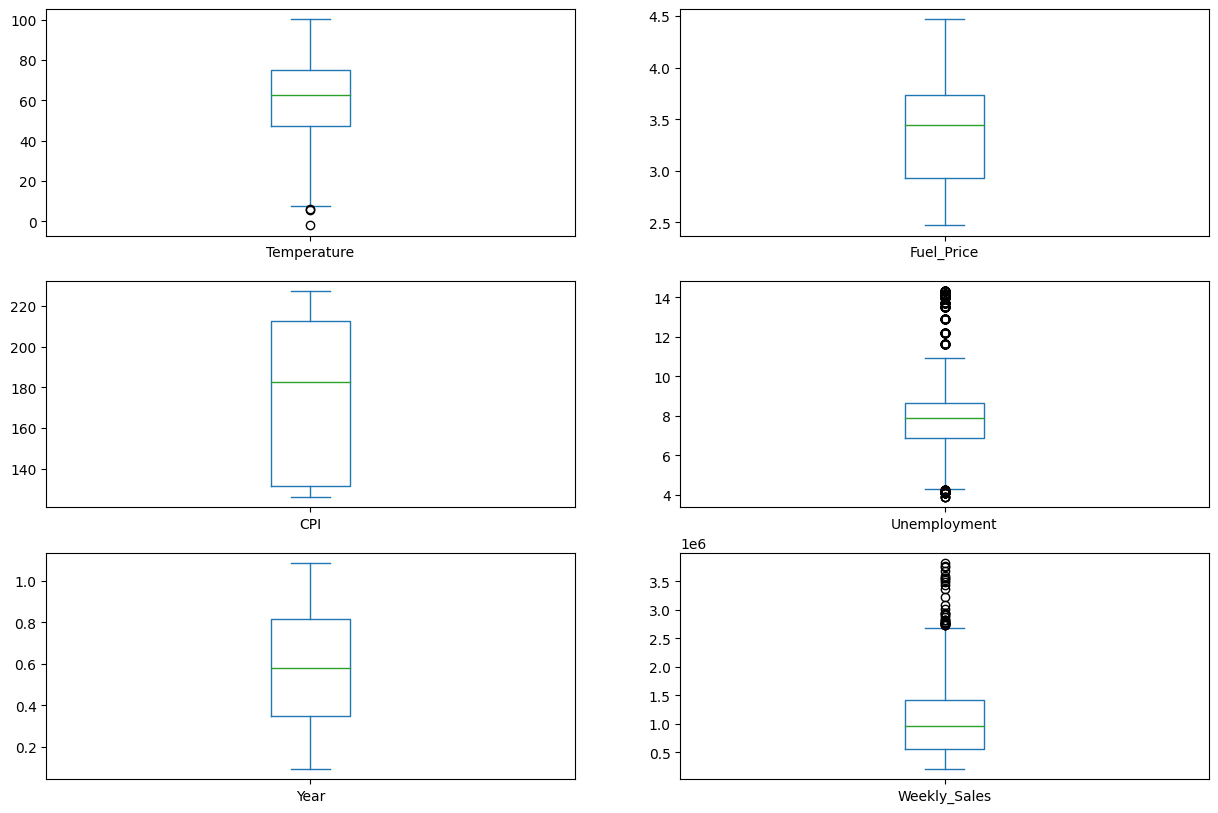

In [18]:
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(15,10))

data['Temperature'].plot(kind='box', ax=axis[0][0])
data['Fuel_Price'].plot(kind='box', ax=axis[0][1])
data['CPI'].plot(kind='box', ax=axis[1][0])
data['Unemployment'].plot(kind='box', ax=axis[1][1])
data['Year'].plot(kind='box', ax=axis[2][0])
data['Weekly_Sales'].plot(kind='box', ax=axis[2][1])

plt.show()

In [19]:
data.corr()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year
Store,1.000000e+00,-0.335332,-4.386841e-16,-0.022659,0.060023,-0.209492,0.223531,-4.138629e-15
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176,6.596560e-02
Holiday_Flag,-4.386841e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960,3.277157e-01
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158,7.383772e-02
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684,-4.980102e-02
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020,1.814709e-03
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000,-2.757378e-03
Year,-4.138629e-15,0.065966,3.277157e-01,0.073838,-0.049801,0.001815,-0.002757,1.000000e+00


In [20]:
columns_outliers = ['Temperature', 'Unemployment']

In [21]:
y = data.pop('Weekly_Sales')
x = data

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=23, stratify=data['Store'])

In [23]:
data_train = pd.concat([x_train, y_train], axis=1)
data_test = pd.concat([x_test, y_test], axis=1)
data_test.to_csv('walmart_test.csv', index=False)
data_train.to_csv('walmart_train.csv', index=False)

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('min_max_scaler', MinMaxScaler(), ['Unemployment']),
        ('std_scaler', StandardScaler(), ['Temperature']),
        ],
    remainder='passthrough'
)

In [25]:
pline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(n_jobs=-1))
])

In [26]:
pline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Unemployment']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['Temperature'])])),
                ('regressor', LinearRegression(n_jobs=-1))])

In [27]:
pline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Unemployment']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['Temperature'])])),
                ('regressor', LinearRegression(n_jobs=-1))])

In [28]:
pline.score(x_test, y_test) # считает r2 метрику по дефолту

0.14040363723513627

In [29]:
y_test.head()

5090     322405.13
3232    1275597.85
5336     334441.15
3740    2119163.01
3129    1097786.14
Name: Weekly_Sales, dtype: float64

In [30]:
pline.predict(x_test)[:5]

array([ 749951.77560076, 1235066.96710633,  862424.50484451,
       1053026.32605279, 1102301.37657249])

In [31]:
np.sqrt(mean_squared_error(y_test, pline.predict(x_test)))

515775.90576220787

Странно что такая большая ошибка и низкий коэфф детерминации, ибо если посмотреть на первые 5 y_test и что выдает конвейер, то модель +- норм предсказывает целевую переменную. Возможно я где-то напортачил, потому что после масштабирования данных метрики чутка упали.

In [105]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=True)

In [106]:
r2_scorer = make_scorer(r2_score)

In [107]:
cross_val_score(pline, x_test, y_test, scoring=make_scorer(r2_score)).mean()

0.1393350399022386

In [108]:
np.sqrt(cross_val_score(pline, x_test, y_test, scoring=mse_scorer)).mean()

528807.9905127918

Кросс валидация показала результаты еще хуже :C

In [109]:
def rf_regressor_scoring(params):
    rf_regressor = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        n_jobs=-1,
        random_state=params['random_state'],
    )

    rf_pline = Pipeline([
       ('preprocessor', preprocessor),
       ('regressor', rf_regressor),
    ])
    
    score = np.sqrt(-cross_val_score(rf_pline, x_test, y_test, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)).mean()

    return score

In [110]:
space = {
    'n_estimators': hp.choice('n_estimators', range(10,201)),
    'max_depth': hp.choice('max_depth', range(5,30)),
    'random_state': hp.choice('random_state', range(0,50))
}

In [111]:
trials = Trials()
best = fmin(
    fn=rf_regressor_scoring,
    space=space,
    algo=tpe.suggest,
    max_evals=200,
    trials=trials,
)

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 200/200 [02:54<00:00,  1.14trial/s, best loss: 161467.64414585516]


In [112]:
best

{'max_depth': 8, 'n_estimators': 80, 'random_state': 9}

In [113]:
best_rf_regressor = RandomForestRegressor(**best)
rf_pline = Pipeline([
       ('preprocessor', preprocessor),
       ('regressor', best_rf_regressor),
    ])

In [114]:
rf_pline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Unemployment']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['Temperature'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=8, n_estimators=80,
                                       random_state=9))])

In [115]:
rf_pline.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Unemployment']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['Temperature'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=8, n_estimators=80,
                                       random_state=9))])

In [116]:
np.sqrt(cross_val_score(rf_pline, x_test, y_test, scoring=mse_scorer, cv=5, n_jobs=-1)).mean()

183925.58532798983

In [117]:
cross_val_score(rf_pline, x_test, y_test, scoring=r2_scorer, cv=5, n_jobs=-1).mean()

0.8949112050932694

In [118]:
def boost_regressor_scoring(params):
    tree_regressor = DecisionTreeRegressor(
        max_depth=params['max_depth'],
        random_state=params['random_state']
    )
    boost_regressor = AdaBoostRegressor(
        estimator=tree_regressor,
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate']/10,
        random_state=23
    )
    boost_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', boost_regressor),
    ])

    score = np.sqrt(-cross_val_score(boost_pipeline,x_test, y_test, scoring='neg_mean_squared_error', cv=5, n_jobs=5)).mean()

    return score

In [119]:
space ={
    'max_depth' : hp.choice('max_depth', range(1,50)),
    'random_state': hp.choice('random_state', range(0,20)),
    'n_estimators': hp.choice('n_estimators', range(50,100)),
    'learning_rate': hp.choice('learning_rate', range(1,10))
}

In [120]:
trials = Trials()
best = fmin(
    fn = boost_regressor_scoring,
    space=space,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 500/500 [06:38<00:00,  1.25trial/s, best loss: 156214.69229982144]


In [156]:
best

{'learning_rate': 2, 'max_depth': 10, 'n_estimators': 24, 'random_state': 7}

`learning_rate` будет 0.1, а не 1 т.к. нельзя передать float в подборку параметров(возможно я что-то не так сделал) и поэтому я при создании бустинг регрессора `learning_rate` делю на 10

In [157]:
trials.best_trial

{'state': 2,
 'tid': 400,
 'spec': None,
 'result': {'loss': 156214.69229982144, 'status': 'ok'},
 'misc': {'tid': 400,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'learning_rate': [400],
   'max_depth': [400],
   'n_estimators': [400],
   'random_state': [400]},
  'vals': {'learning_rate': [2],
   'max_depth': [10],
   'n_estimators': [24],
   'random_state': [7]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 1, 31, 18, 10, 48, 333000),
 'refresh_time': datetime.datetime(2024, 1, 31, 18, 10, 49, 33000)}

In [158]:
decisiontree = DecisionTreeRegressor(
        max_depth=best['max_depth'],
        random_state=best['random_state']
)
boost_regressor = AdaBoostRegressor(
        estimator=decisiontree,
        n_estimators=best['n_estimators'],
        learning_rate=best['learning_rate']/10,
        random_state=23
)
boost_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', boost_regressor),
    ])

In [159]:
boost_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Unemployment']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['Temperature'])])),
                ('regressor',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10,
                                                                   random_state=7),
                                   learning_rate=0.2, n_estimators=24,
                                   random_state=23))])

In [165]:
boost_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Unemployment']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['Temperature'])])),
                ('regressor',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10,
                                                                   random_state=7),
                                   learning_rate=0.2, n_estimators=24,
                                   random_state=23))])

In [166]:
cross_val_score(boost_pipeline, x_test, y_test, scoring=r2_scorer, cv=5, verbose=1).mean()

0.9119732924164593

In [220]:
r2_score(y_test, boost_pipeline.predict(x_test))

0.9354241853210387

In [174]:
x_train = x_train.astype(np.float32)

In [175]:
onnx = to_onnx(boost_pipeline, x_train, verbose=1)

[to_onnx] initial_types=[('Store', FloatTensorType(shape=[None, 1])), ('Holiday_Flag', FloatTensorType(shape=[None, 1])), ('Temperature', FloatTensorType(shape=[None, 1])), ('Fuel_Price', FloatTensorType(shape=[None, 1])), ('CPI', FloatTensorType(shape=[None, 1])), ('Unemployment', FloatTensorType(shape=[None, 1])), ('Year', FloatTensorType(shape=[None, 1]))]
[convert_sklearn] parse_sklearn_model
[convert_sklearn] convert_topology
[convert_operators] begin
[convert_operators] iteration 1 - n_vars=0 n_ops=5
[call_converter] call converter for 'SklearnMinMaxScaler'.
[call_converter] call converter for 'SklearnScaler'.
[call_converter] call converter for 'SklearnConcat'.
[call_converter] call converter for 'SklearnConcat'.
[call_converter] call converter for 'SklearnAdaBoostRegressor'.
[convert_operators] end iter: 1 - n_vars=24
[convert_operators] iteration 2 - n_vars=24 n_ops=29
[call_converter] call converter for 'SklearnDecisionTreeRegressor'.
[call_converter] call converter for 'Skle

In [176]:
onnxmltools.utils.save_model(onnx, 'regressor.model.onnx')

In [177]:
session = rt.InferenceSession('regressor.model.onnx')

In [204]:
x_test = x_test.astype(np.float32)

In [211]:
input_data = x_test.values
y_pred = np.full(shape=(len(x_test)), fill_value=np.nan)

In [216]:
for i in range(len(x_test)):
    inputs = {}
    for j in range(len(x_test.columns)):
        inputs[x_test.columns[j]] = np.full(shape=(1,1), fill_value=x_test.iloc[i,j])
    y_pred[i] = session.run(None, inputs)[0][0][0]

In [207]:
y_pred

[array([[287710.72]], dtype=float32)]

In [208]:
y_pred = np.full(shape=(len(x_train)), fill_value=np.nan)

for i in range(len(x_train)):
    inputs = {}
    for j in range(len(x_train.columns)):
        inputs[x_train.columns[j]] = np.full(shape=(1,1), fill_value=x_train.iloc[i,j])

    sess_pred = session.run(None, inputs)
    y_pred[i] = sess_pred[0][0][0]

In [218]:
y_pred

array([ 622883.8125, 1500485.875 ,  811047.375 , ...,  709796.125 ,
        937726.375 , 1179190.25  ])

In [219]:
r2_score(y_test, y_pred)

0.9354241863146272

Вывод
-------
В ходе работы были использованы алгоритмы для регрессии **LinearRegression, RandomForestRegressor и AdaBoostRegressor**. В **AdaBoostRegressor** в качестве *estimator* был выбран алгоритм **DecisionTreeRegressor**. Под каждый алгоритм был создан свой собственный конвейер, где единственным отличием был последний элемент - *regressor*. Для обработки выбросов в конвейере были использованы алгоритмы масштабирования: **StandardScaler и MinMaxScaler**. Оптимизация гиперпараметров осуществлялась при помощи библиотеки **hyperopt**. Лучшим вариантом для решения задачи регрессии оказался алгоритм **AdaBoostRegressor** с **DecisionTreeRegressor**. Для оценивания работы алгоритмов использовались метрики **MSE** и **R2-score**. Коэффициент детерминации лучшей модели по результатам кросс-валидации равен **`0.9119732924164593`**. В конце работы эта модель была импортирована в файл `regressor.model.onnx`, а также экспортирована для проверки работоспособности.